In [1]:
import xarray as xr
import numpy as np
from torch.utils.data import DataLoader

# Open the NetCDF files using xarray
accum_ds = xr.open_dataset('era5_data/data_stream-oper_stepType-accum.nc')
instant_ds = xr.open_dataset('era5_data/data_stream-oper_stepType-instant.nc')
pressure_ds = xr.open_dataset('era5_data/pressure_levels_reduced.nc')

# Check the available variables
print("Accumulated data variables:", accum_ds.variables)
print("Instantaneous data variables:", instant_ds.variables)
print("Pressure-level data variables:", pressure_ds.variables)

Accumulated data variables: Frozen({'number': <xarray.Variable ()> Size: 8B
[1 values with dtype=int64]
Attributes:
    long_name:      ensemble member numerical id
    units:          1
    standard_name:  realization, 'valid_time': <xarray.IndexVariable 'valid_time' (valid_time: 1460)> Size: 12kB
array(['2022-01-01T06:00:00.000000000', '2022-01-01T18:00:00.000000000',
       '2022-01-02T06:00:00.000000000', ..., '2023-12-30T18:00:00.000000000',
       '2023-12-31T06:00:00.000000000', '2023-12-31T18:00:00.000000000'],
      dtype='datetime64[ns]')
Attributes:
    long_name:      time
    standard_name:  time, 'latitude': <xarray.IndexVariable 'latitude' (latitude: 133)> Size: 1kB
array([63.  , 62.75, 62.5 , 62.25, 62.  , 61.75, 61.5 , 61.25, 61.  , 60.75,
       60.5 , 60.25, 60.  , 59.75, 59.5 , 59.25, 59.  , 58.75, 58.5 , 58.25,
       58.  , 57.75, 57.5 , 57.25, 57.  , 56.75, 56.5 , 56.25, 56.  , 55.75,
       55.5 , 55.25, 55.  , 54.75, 54.5 , 54.25, 54.  , 53.75, 53.5 , 53.25,
  

In [2]:
print("Available pressure levels:", pressure_ds.pressure_level.values)

Available pressure levels: [850. 500.]


In [3]:
# Get sample time point
sample_time = accum_ds.valid_time[0].values

# Extract input variables
input_vars = []

# From instantaneous dataset (2D surface variables)
input_vars.append(instant_ds['t2m'].sel(valid_time=sample_time).values[None,...])  # Shape (1, 133, 293)
input_vars.append(instant_ds['v10'].sel(valid_time=sample_time).values[None,...])
input_vars.append(instant_ds['tcc'].sel(valid_time=sample_time).values[None,...])
input_vars.append(instant_ds['msl'].sel(valid_time=sample_time).values[None,...])
input_vars.append(instant_ds['u10'].sel(valid_time=sample_time).values[None,...])

# From pressure-level dataset - use available levels
input_vars.append(pressure_ds['z'].sel(valid_time=sample_time, pressure_level=500).values[None,...])  # 500 hPa
input_vars.append(pressure_ds['r'].sel(valid_time=sample_time, pressure_level=850).values[None,...])  # 850 hPa
input_vars.append(pressure_ds['t'].sel(valid_time=sample_time, pressure_level=850).values[None,...])  # Use 850 hPa for temperature

# Stack inputs
input_sample = np.concatenate(input_vars, axis=0)
print(f"✅ Final input shape: {input_sample.shape}")  # Should be (8, 133, 293)

# Get target
target_sample = accum_ds['tp'].sel(valid_time=sample_time).values[None,...]  # Add channel dim
print(f"✅ Target shape: {target_sample.shape} (1, 133, 293)")

✅ Final input shape: (8, 133, 293)
✅ Target shape: (1, 133, 293) (1, 133, 293)


In [4]:
import os
import pickle
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
from tqdm import tqdm  # Import tqdm for progress bar

def compute_and_save_stats(accum_ds, instant_ds, pressure_ds, 
                         stats_path='weather_stats.pkl', 
                         force_recompute=False,
                         subsample=None):
    """Precompute and save normalization statistics with progress bar"""
    if not force_recompute and os.path.exists(stats_path):
        print(f"📊 Loading existing stats from {stats_path}")
        with open(stats_path, 'rb') as f:
            return pickle.load(f)
    
    print("🔢 Computing normalization statistics...")
    valid_times = accum_ds.valid_time.values
    
    # Apply subsampling if requested
    if subsample is not None:
        valid_times = valid_times[::subsample]
    
    # Initialize accumulators
    n_samples = len(valid_times)
    sum_ = np.zeros(8)  # 8 input channels
    sum_sq = np.zeros(8)
    
    # Create progress bar
    pbar = tqdm(total=n_samples, desc="Processing samples", unit="sample")
    
    for valid_time in valid_times:
        # Get sample data
        t2m = instant_ds['t2m'].sel(valid_time=valid_time).values
        v10 = instant_ds['v10'].sel(valid_time=valid_time).values
        tcc = instant_ds['tcc'].sel(valid_time=valid_time).values
        msl = instant_ds['msl'].sel(valid_time=valid_time).values
        u10 = instant_ds['u10'].sel(valid_time=valid_time).values
        z = pressure_ds['z'].sel(valid_time=valid_time, pressure_level=500).values
        r = pressure_ds['r'].sel(valid_time=valid_time, pressure_level=850).values
        t = pressure_ds['t'].sel(valid_time=valid_time, pressure_level=850).values
        
        sample = np.stack([t2m, v10, tcc, msl, u10, z, r, t])
        
        # Update running stats
        sum_ += np.sum(sample, axis=(1, 2))
        sum_sq += np.sum(sample**2, axis=(1, 2))
        
        # Update progress bar
        pbar.update(1)
    
    pbar.close()
    
    # Compute final stats
    n_pixels = sample.shape[1] * sample.shape[2] * n_samples
    mean = sum_ / n_pixels
    std = np.sqrt((sum_sq / n_pixels) - mean**2)
    
    stats = {
        'mean': mean,
        'std': std,
        'n_samples': n_samples,
        'computed_on': str(pd.Timestamp.now())
    }
    
    # Save to file
    with open(stats_path, 'wb') as f:
        pickle.dump(stats, f)
    print(f"💾 Saved stats to {stats_path} (based on {n_samples} samples)")
    
    return stats

class WeatherDataset(Dataset):
    def __init__(self, accum_ds, instant_ds, pressure_ds, stats_path='weather_stats.pkl', force_recompute=False):
        self.accum_ds = accum_ds
        self.instant_ds = instant_ds
        self.pressure_ds = pressure_ds
        self.valid_times = accum_ds.valid_time.values
        
        # Load or compute stats
        stats = compute_and_save_stats(accum_ds, instant_ds, pressure_ds, stats_path, force_recompute)
        self.mean = stats['mean']
        self.std = stats['std']
        
        print("Normalization stats loaded:")
        print(f"Means: {self.mean}")
        print(f"Stds: {self.std}")
    
    def _get_sample(self, valid_time):
        """Helper to get raw sample data"""
        # Surface variables
        t2m = self.instant_ds['t2m'].sel(valid_time=valid_time).values
        v10 = self.instant_ds['v10'].sel(valid_time=valid_time).values
        tcc = self.instant_ds['tcc'].sel(valid_time=valid_time).values
        msl = self.instant_ds['msl'].sel(valid_time=valid_time).values
        u10 = self.instant_ds['u10'].sel(valid_time=valid_time).values
        
        # Pressure-level variables
        z = self.pressure_ds['z'].sel(valid_time=valid_time, pressure_level=500).values
        r = self.pressure_ds['r'].sel(valid_time=valid_time, pressure_level=850).values
        t = self.pressure_ds['t'].sel(valid_time=valid_time, pressure_level=850).values
        
        return np.stack([t2m, v10, tcc, msl, u10, z, r, t], axis=0)
    
    def __len__(self):
        return len(self.valid_times)
    
    def __getitem__(self, idx):
        valid_time = self.valid_times[idx]
        X = self._get_sample(valid_time)
        y = self.accum_ds['tp'].sel(valid_time=valid_time).values[np.newaxis]
        
        # Normalize
        X = (X - self.mean[:, None, None]) / self.std[:, None, None]
            
        return torch.FloatTensor(X), torch.FloatTensor(y)

In [5]:
# First time usage (computes and saves stats)
dataset = WeatherDataset(accum_ds, instant_ds, pressure_ds)

📊 Loading existing stats from weather_stats.pkl
Normalization stats loaded:
Means: [ 2.86241748e+02 -1.15519458e-01  5.67562688e-01  1.01487929e+05
  8.61177750e-01  5.53012735e+04  6.08969971e+01  2.79718385e+02]
Stds: [8.79953011e+00 4.34716854e+00 3.94025224e-01 1.00896768e+03
 4.56978167e+00 1.82832945e+03 2.65714561e+01 8.61030985e+00]


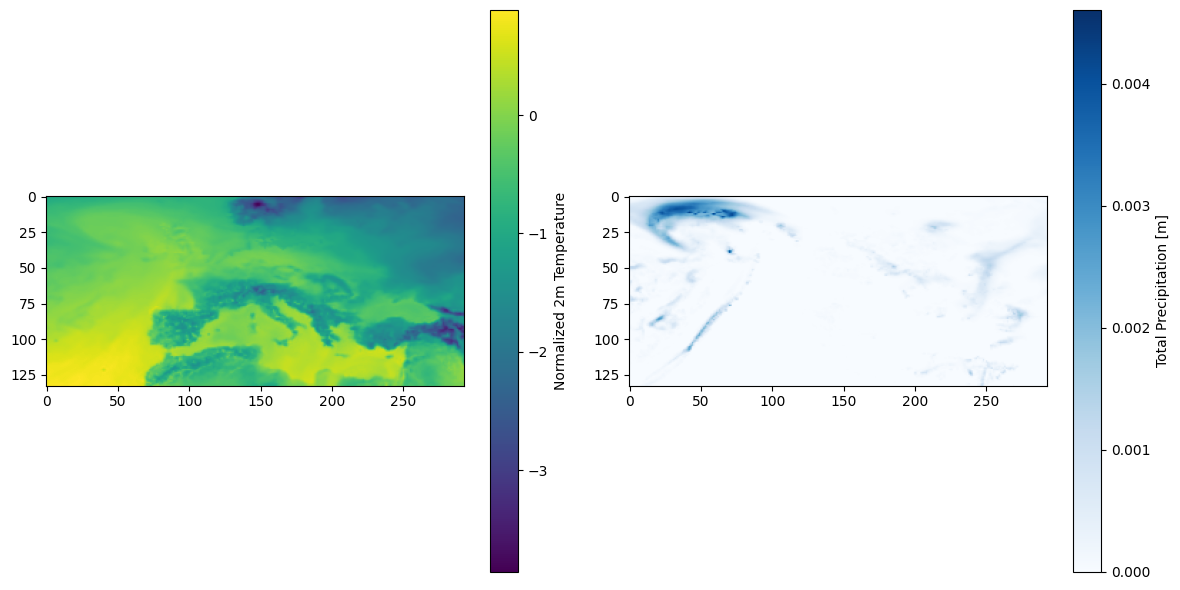

In [6]:
import matplotlib.pyplot as plt

def plot_sample(X, y):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(X[0], cmap='viridis')
    plt.colorbar(label='Normalized 2m Temperature')
    plt.subplot(1, 2, 2)
    plt.imshow(y.squeeze(), cmap='Blues', vmin=0)
    plt.colorbar(label='Total Precipitation [m]')
    plt.tight_layout()
    plt.show()

X_sample, y_sample = next(iter(DataLoader(dataset, batch_size=1)))
plot_sample(X_sample[0].numpy(), y_sample[0].numpy())

In [7]:
from torch.utils.data import DataLoader, random_split
import torch

# Create full dataset
full_dataset = WeatherDataset(accum_ds, instant_ds, pressure_ds)

# Calculate split sizes
total_size = len(full_dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

# Split with fixed random seed for reproducibility
generator = torch.Generator().manual_seed(42)  # For consistent splits
train_ds, val_ds, test_ds = random_split(
    full_dataset, 
    [train_size, val_size, test_size],
    generator=generator
)

val_indices = list(range(len(val_ds)))

# Create data loaders
batch_size = 1
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)
test_loader = DataLoader(test_ds, batch_size=batch_size)

print(f"Dataset sizes: Train {len(train_ds)}, Val {len(val_ds)}, Test {len(test_ds)}")
print(f"Batch counts: Train {len(train_loader)}, Val {len(val_loader)}, Test {len(test_loader)}")

📊 Loading existing stats from weather_stats.pkl
Normalization stats loaded:
Means: [ 2.86241748e+02 -1.15519458e-01  5.67562688e-01  1.01487929e+05
  8.61177750e-01  5.53012735e+04  6.08969971e+01  2.79718385e+02]
Stds: [8.79953011e+00 4.34716854e+00 3.94025224e-01 1.00896768e+03
 4.56978167e+00 1.82832945e+03 2.65714561e+01 8.61030985e+00]
Dataset sizes: Train 1168, Val 146, Test 146
Batch counts: Train 1168, Val 146, Test 146


In [8]:
import matplotlib.pyplot as plt
import numpy as np

def plot_dataloader_sample(loader, channel_names=None):
    """Plot a random batch from a data loader"""
    # Get a batch
    X, y = next(iter(loader))
    
    # Select random sample from batch
    idx = torch.randint(0, X.shape[0], (1,)).item()
    X_sample = X[idx].numpy()
    y_sample = y[idx].numpy()
    
    # Create figure
    plt.figure(figsize=(15, 10))
    
    # Plot input channels (3x3 grid)
    for i in range(min(8, 9)):  # Show up to 8 inputs (9th slot for target)
        plt.subplot(3, 3, i+1)
        plt.imshow(X_sample[i], cmap='viridis')
        plt.colorbar()
        if channel_names and i < len(channel_names):
            plt.title(f"Input: {channel_names[i]}")
        else:
            plt.title(f"Channel {i}")
    
    # Plot target precipitation (last subplot)
    plt.subplot(3, 3, 9)
    precip = y_sample.squeeze()
    plt.imshow(precip, cmap='Blues', vmin=0, vmax=np.percentile(precip, 99))
    plt.colorbar(label='Precipitation [m]')
    plt.title("Target Precipitation")
    
    plt.tight_layout()
    plt.show()

# Define your channel names (match your input order)
channel_names = [
    '2m Temperature [K]',
    '10m V Wind [m/s]',
    'Total Cloud Cover',
    'Mean Sea Level Pressure [Pa]',
    '10m U Wind [m/s]',
    '500hPa Geopotential [m²/s²]',
    '850hPa Relative Humidity',
    '850hPa Temperature [K]'
]

=== Training Set ===


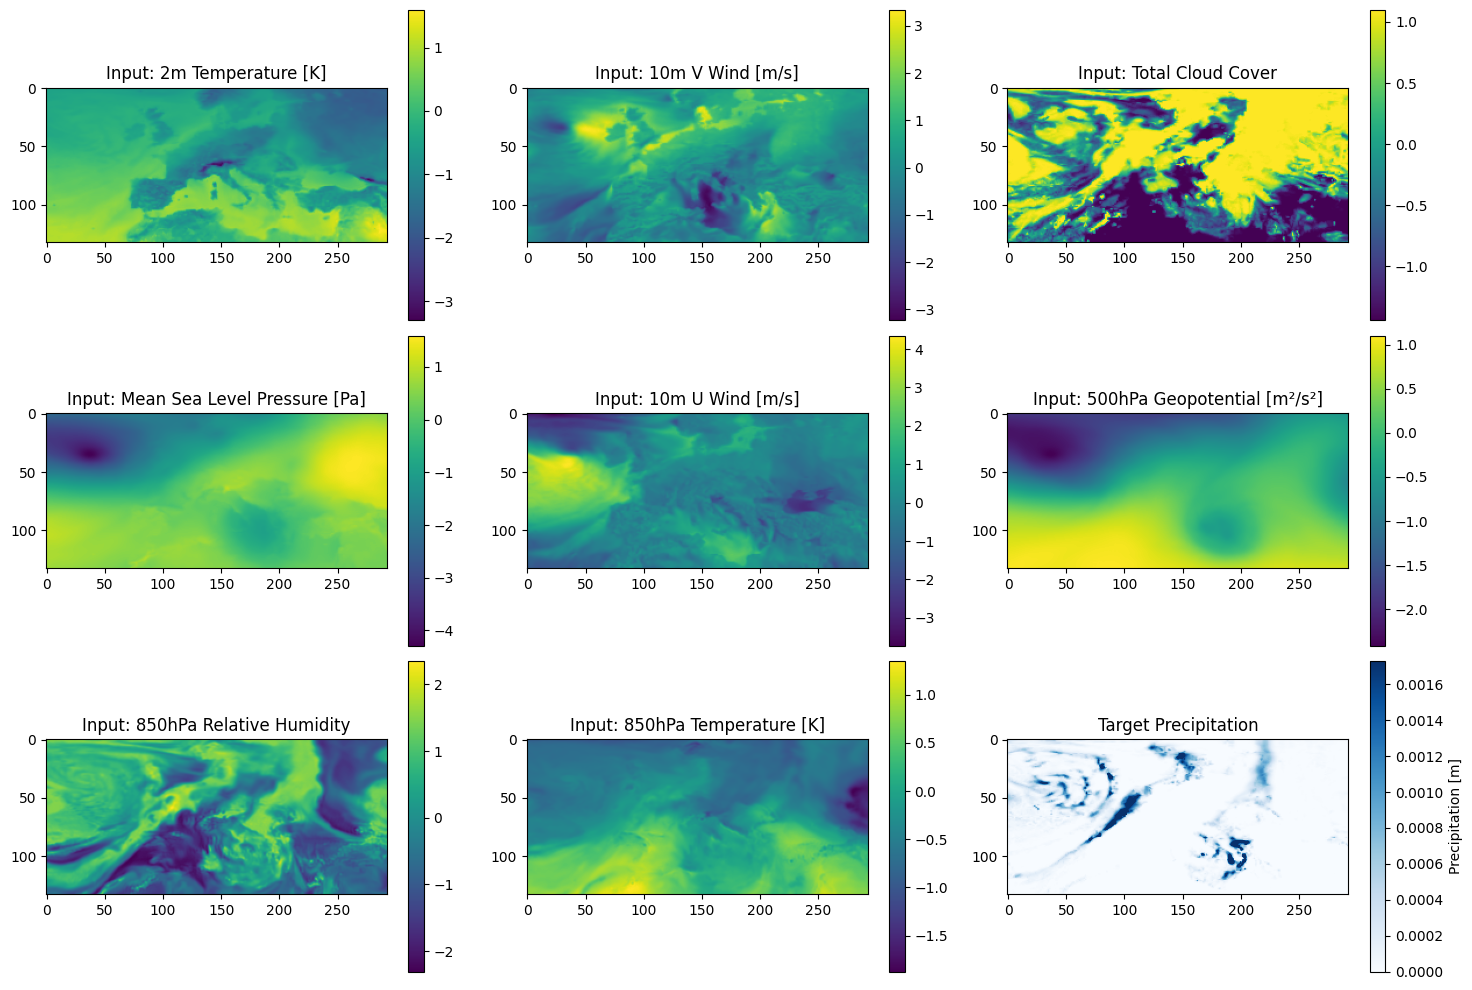

In [9]:
# Plot samples from each loader
print("=== Training Set ===")
plot_dataloader_sample(train_loader, channel_names)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import wandb

# Initialize wandb
wandb.init(project="precipitation-prediction-unet", 
           config={
               "learning_rate": 1e-4,
               "batch_size": batch_size,
               "epochs": 50,
               "architecture": "U-Net"
           })

# Define U-Net model (simplified version)
class UNet(nn.Module):
    def __init__(self, in_channels=8, out_channels=1):
        super().__init__()
        
        def double_conv(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, 3, padding=1),
                nn.ReLU(inplace=True)
            )
        
        # Downsample path
        self.dconv_down1 = double_conv(in_channels, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.maxpool = nn.MaxPool2d(2)
        
        # Upsample path
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(64 + 128, 64)
        
        # Final layer
        self.conv_last = nn.Conv2d(64, out_channels, 1)
        
    def forward(self, x):
        # Encoder
        conv1 = self.dconv_down1(x)  # Original size
        x = self.maxpool(conv1)
        
        conv2 = self.dconv_down2(x)  # Half size
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)  # Quarter size
        
        # Decoder
        x = self.upsample(conv3)
        # Handle dimension mismatch with padding
        diffY = conv2.size()[2] - x.size()[2]
        diffX = conv2.size()[3] - x.size()[3]
        x = F.pad(x, [diffX // 2, diffX - diffX // 2,
                      diffY // 2, diffY - diffY // 2])
        x = torch.cat([x, conv2], dim=1)
        x = self.dconv_up2(x)
        
        x = self.upsample(x)
        # Handle dimension mismatch with padding
        diffY = conv1.size()[2] - x.size()[2]
        diffX = conv1.size()[3] - x.size()[3]
        x = F.pad(x, [diffX // 2, diffX - diffX // 2,
                      diffY // 2, diffY - diffY // 2])
        x = torch.cat([x, conv1], dim=1)
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        return out

In [11]:
import torch.nn.functional as F

# Initialize model, loss, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(in_channels=8, out_channels=1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate)

import os
import matplotlib.pyplot as plt
from datetime import datetime

def train_model(model, train_loader, val_loader, epochs=50):
    best_val_loss = float('inf')
    step = 0
    
    # Create single output directory
    output_dir = "validation_images"
    os.makedirs(output_dir, exist_ok=True)
    
    # Initial validation before training starts
    model.eval()
    with torch.no_grad():
        X_val, y_val = next(iter(val_loader))
        X_val, y_val = X_val.to(device), y_val.to(device)
        preds = model(X_val)
        save_comparison_images(X_val, y_val, preds, step, output_dir)
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        
        with tqdm(train_loader, unit="batch", desc=f"Epoch {epoch+1}/{epochs}") as tepoch:
            for X_batch, y_batch in tepoch:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                #print(X_batch.shape, y_batch.shape)
                #print(X_batch.mean())
                
                optimizer.zero_grad()
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item() * X_batch.size(0)
                step += 1
                tepoch.set_postfix(loss=loss.item())
                wandb.log({"batch_train_loss": loss.item()}, step=step)
                
                # Validation every 500 steps
                if step % 200 == 0:
                    model.eval()
                    with torch.no_grad():
                        # Select random sample from full validation set
                        random_idx = np.random.choice(val_indices)
                        X_val, y_val = val_ds[random_idx]
                        X_val = X_val.unsqueeze(0).to(device)  # Add batch dimension
                        y_val = y_val.unsqueeze(0).to(device)
                        preds = model(X_val)
                        val_loss = criterion(preds, y_val).item()
                        
                        # Save with unique filename
                        save_comparison_images(X_val, y_val, preds, step, output_dir)
                        wandb.log({"val_loss": val_loss}, step=step)
                    
                    model.train()
        
        # Epoch-end validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_loss += criterion(model(X_val), y_val).item() * X_val.size(0)
        
        val_loss /= len(val_loader.dataset)
        wandb.log({
            "epoch_train_loss": train_loss/len(train_loader.dataset),
            "epoch_val_loss": val_loss,
            "epoch": epoch+1
        }, step=step)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_unet_model.pth")
            #wandb.save("best_unet_model.pth")

def save_comparison_images(X_val, y_val, preds, step, output_dir):
    """Save comparison images to fixed directory"""
    # Convert to numpy
    X_val = X_val.cpu().numpy()
    y_val = y_val.cpu().numpy()
    preds = preds.cpu().numpy()
    
    # Select random sample from batch
    idx = np.random.randint(0, X_val.shape[0])
    print(X_val.shape, y_val.shape)
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Ground truth
    im1 = ax1.imshow(y_val[idx].squeeze(), cmap='Blues', vmin=0)
    ax1.set_title("Ground Truth")
    plt.colorbar(im1, ax=ax1)
    
    # Prediction
    im2 = ax2.imshow(preds[idx].squeeze(), cmap='Blues', vmin=0)
    ax2.set_title(f"Prediction (Step {step})")
    plt.colorbar(im2, ax=ax2)
    
    # Save with fixed filename (overwrites previous)
    save_path = os.path.join(output_dir, f"validation_step_{step:05d}.png")
    plt.savefig(save_path, bbox_inches='tight', dpi=150)
    plt.close()
    
    # # Also save step-specific version
    # step_path = os.path.join(output_dir, f"step_{step:05d}.png")
    # plt.savefig(step_path, bbox_inches='tight', dpi=150)
    # plt.close()

In [12]:
# Start training
trained_model = train_model(model, train_loader, val_loader)

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 1/50:  17%|████████▌                                         | 199/1168 [06:36<32:35,  2.02s/batch, loss=9.17e-7]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 1/50:  34%|█████████████████                                 | 399/1168 [13:14<25:23,  1.98s/batch, loss=4.92e-7]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 1/50:  51%|█████████████████████████▋                        | 599/1168 [19:52<18:37,  1.96s/batch, loss=1.66e-7]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 1/50:  68%|██████████████████████████████████▏               | 799/1168 [26:31<12:08,  1.97s/batch, loss=1.55e-7]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 1/50:  86%|██████████████████████████████████████████▊       | 999/1168 [33:09<05:32,  1.97s/batch, loss=1.75e-7]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 2/50:   3%|█▎                                                 | 31/1168 [01:03<37:01,  1.95s/batch, loss=1.05e-7]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 2/50:  20%|█████████▉                                        | 231/1168 [07:41<30:35,  1.96s/batch, loss=9.29e-8]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 2/50:  37%|██████████████████▊                                | 431/1168 [14:19<24:42,  2.01s/batch, loss=1.3e-7]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 2/50:  54%|███████████████████████████                       | 631/1168 [20:57<17:23,  1.94s/batch, loss=7.94e-8]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 2/50:  71%|███████████████████████████████████▌              | 831/1168 [27:35<11:18,  2.01s/batch, loss=1.31e-7]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 2/50:  88%|███████████████████████████████████████████▎     | 1031/1168 [34:14<04:33,  2.00s/batch, loss=5.95e-8]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 3/50:   5%|██▊                                                | 63/1168 [02:06<36:37,  1.99s/batch, loss=4.55e-8]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 3/50:  23%|███████████▎                                      | 263/1168 [08:44<30:20,  2.01s/batch, loss=6.38e-8]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 3/50:  40%|████████████████████▏                              | 463/1168 [15:24<23:16,  1.98s/batch, loss=1.6e-7]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 3/50:  57%|████████████████████████████▍                     | 663/1168 [22:04<16:31,  1.96s/batch, loss=8.42e-8]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 3/50:  74%|████████████████████████████████████▉             | 863/1168 [28:44<10:01,  1.97s/batch, loss=5.32e-8]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 3/50:  91%|████████████████████████████████████████████▌    | 1063/1168 [35:24<03:31,  2.01s/batch, loss=5.58e-8]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 4/50:   8%|████▏                                              | 95/1168 [03:11<35:53,  2.01s/batch, loss=1.13e-7]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 4/50:  25%|████████████▋                                     | 295/1168 [09:51<28:56,  1.99s/batch, loss=2.56e-8]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 4/50:  42%|█████████████████████▏                            | 495/1168 [16:33<22:33,  2.01s/batch, loss=6.47e-8]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 4/50:  60%|█████████████████████████████▊                    | 695/1168 [23:15<15:48,  2.01s/batch, loss=1.12e-7]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 4/50:  77%|██████████████████████████████████████▎           | 895/1168 [29:58<09:06,  2.00s/batch, loss=7.63e-8]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 4/50:  94%|█████████████████████████████████████████████▉   | 1095/1168 [36:41<02:25,  2.00s/batch, loss=1.21e-7]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 5/50:  11%|█████▍                                            | 127/1168 [04:19<35:14,  2.03s/batch, loss=8.69e-8]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 5/50:  28%|█████████████▉                                    | 327/1168 [11:07<28:26,  2.03s/batch, loss=3.51e-8]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 5/50:  45%|██████████████████████▌                           | 527/1168 [17:52<21:40,  2.03s/batch, loss=4.17e-8]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 5/50:  62%|███████████████████████████████                   | 727/1168 [24:37<14:40,  2.00s/batch, loss=1.01e-7]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 5/50:  79%|███████████████████████████████████████▋          | 927/1168 [31:29<08:19,  2.07s/batch, loss=7.47e-8]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 5/50:  96%|███████████████████████████████████████████████▎ | 1127/1168 [38:23<01:24,  2.07s/batch, loss=9.77e-8]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 6/50:  14%|██████▊                                           | 159/1168 [05:30<34:28,  2.05s/batch, loss=8.52e-8]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 6/50:  31%|███████████████▎                                  | 359/1168 [12:25<27:57,  2.07s/batch, loss=1.57e-7]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 6/50:  48%|███████████████████████▉                          | 559/1168 [19:21<21:01,  2.07s/batch, loss=3.02e-8]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 6/50:  65%|████████████████████████████████▍                 | 759/1168 [26:17<14:06,  2.07s/batch, loss=4.67e-8]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 6/50:  82%|█████████████████████████████████████████         | 959/1168 [33:13<07:10,  2.06s/batch, loss=7.18e-8]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 6/50:  99%|████████████████████████████████████████████████▌| 1159/1168 [40:10<00:18,  2.09s/batch, loss=8.41e-8]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 7/50:  16%|████████▏                                         | 191/1168 [06:38<34:14,  2.10s/batch, loss=6.74e-8]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 7/50:  33%|████████████████▋                                 | 391/1168 [13:35<26:53,  2.08s/batch, loss=6.38e-8]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 7/50:  51%|█████████████████████████▎                        | 591/1168 [20:32<20:05,  2.09s/batch, loss=7.22e-8]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 7/50:  68%|█████████████████████████████████▊                | 791/1168 [27:29<12:53,  2.05s/batch, loss=5.83e-8]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 7/50:  85%|██████████████████████████████████████████▍       | 991/1168 [34:29<06:05,  2.06s/batch, loss=9.94e-8]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 8/50:   2%|█                                                  | 23/1168 [00:49<39:47,  2.09s/batch, loss=6.59e-8]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 8/50:  19%|█████████▌                                        | 223/1168 [07:46<32:25,  2.06s/batch, loss=3.56e-8]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 8/50:  36%|██████████████████                                | 423/1168 [14:43<26:03,  2.10s/batch, loss=7.93e-8]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 8/50:  53%|██████████████████████████▋                       | 623/1168 [21:41<18:44,  2.06s/batch, loss=3.45e-8]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 8/50:  70%|███████████████████████████████████▏              | 823/1168 [28:37<11:48,  2.05s/batch, loss=3.41e-8]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 8/50:  88%|██████████████████████████████████████████▉      | 1023/1168 [35:34<05:02,  2.08s/batch, loss=6.38e-8]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 9/50:   5%|██▍                                                | 55/1168 [01:56<38:56,  2.10s/batch, loss=7.16e-8]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 9/50:  22%|██████████▉                                       | 255/1168 [08:38<30:42,  2.02s/batch, loss=1.22e-7]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 9/50:  39%|███████████████████▍                              | 455/1168 [15:21<23:47,  2.00s/batch, loss=1.37e-7]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 9/50:  56%|████████████████████████████                      | 655/1168 [22:04<17:06,  2.00s/batch, loss=8.55e-8]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 9/50:  73%|████████████████████████████████████▌             | 855/1168 [28:49<10:23,  1.99s/batch, loss=6.09e-8]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 9/50:  90%|████████████████████████████████████████████▎    | 1055/1168 [35:34<03:43,  1.98s/batch, loss=2.78e-8]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 10/50:   7%|███▋                                              | 87/1168 [02:57<35:49,  1.99s/batch, loss=5.57e-8]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 10/50:  25%|████████████                                     | 287/1168 [09:50<30:31,  2.08s/batch, loss=1.04e-7]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 10/50:  42%|████████████████████▊                             | 487/1168 [16:46<23:17,  2.05s/batch, loss=5.9e-8]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 10/50:  59%|████████████████████████████▊                    | 687/1168 [23:33<16:10,  2.02s/batch, loss=7.29e-8]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 10/50:  76%|█████████████████████████████████████▏           | 887/1168 [30:18<09:20,  2.00s/batch, loss=9.33e-8]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 10/50:  93%|████████████████████████████████████████████▋   | 1087/1168 [37:04<02:41,  1.99s/batch, loss=5.51e-8]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 11/50:  10%|████▉                                            | 119/1168 [04:05<35:33,  2.03s/batch, loss=6.89e-8]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 11/50:  27%|█████████████▍                                   | 319/1168 [11:00<29:09,  2.06s/batch, loss=1.09e-7]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 11/50:  44%|█████████████████████▊                           | 519/1168 [17:55<22:20,  2.07s/batch, loss=1.15e-7]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 11/50:  62%|██████████████████████████████▏                  | 719/1168 [24:50<15:25,  2.06s/batch, loss=1.16e-7]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 11/50:  79%|██████████████████████████████████████▌          | 919/1168 [31:46<08:45,  2.11s/batch, loss=4.79e-8]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 11/50:  96%|█████████████████████████████████████████████▉  | 1119/1168 [38:42<01:42,  2.08s/batch, loss=3.22e-8]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 12/50:  13%|██████▍                                           | 151/1168 [05:14<35:21,  2.09s/batch, loss=5.7e-8]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 12/50:  30%|██████████████▋                                  | 351/1168 [12:12<29:09,  2.14s/batch, loss=3.65e-8]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 12/50:  47%|███████████████████████                          | 551/1168 [19:10<21:07,  2.05s/batch, loss=3.87e-8]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 12/50:  64%|███████████████████████████████▌                 | 751/1168 [26:07<14:17,  2.06s/batch, loss=5.36e-8]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 12/50:  81%|███████████████████████████████████████▉         | 951/1168 [33:06<07:30,  2.08s/batch, loss=1.17e-7]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 12/50:  99%|███████████████████████████████████████████████▎| 1151/1168 [40:02<00:35,  2.08s/batch, loss=1.58e-7]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 13/50:  16%|███████▋                                         | 183/1168 [06:21<34:21,  2.09s/batch, loss=9.91e-8]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 13/50:  33%|████████████████                                 | 383/1168 [13:19<27:17,  2.09s/batch, loss=6.45e-8]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 13/50:  50%|████████████████████████▍                        | 583/1168 [20:20<20:15,  2.08s/batch, loss=3.02e-8]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 13/50:  67%|████████████████████████████████▊                | 783/1168 [27:19<13:28,  2.10s/batch, loss=2.58e-8]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 13/50:  84%|█████████████████████████████████████████▏       | 983/1168 [34:18<06:20,  2.06s/batch, loss=2.54e-8]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 14/50:   1%|▋                                                 | 15/1168 [00:33<40:12,  2.09s/batch, loss=6.53e-8]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 14/50:  18%|█████████                                        | 215/1168 [07:30<32:35,  2.05s/batch, loss=5.07e-8]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 14/50:  36%|█████████████████▍                               | 415/1168 [14:33<26:29,  2.11s/batch, loss=3.28e-8]

(1, 8, 133, 293) (1, 1, 133, 293)


Epoch 14/50:  37%|█████████████████▉                               | 428/1168 [15:03<26:01,  2.11s/batch, loss=5.04e-8]


KeyboardInterrupt: 

Using random seed: 1743851462


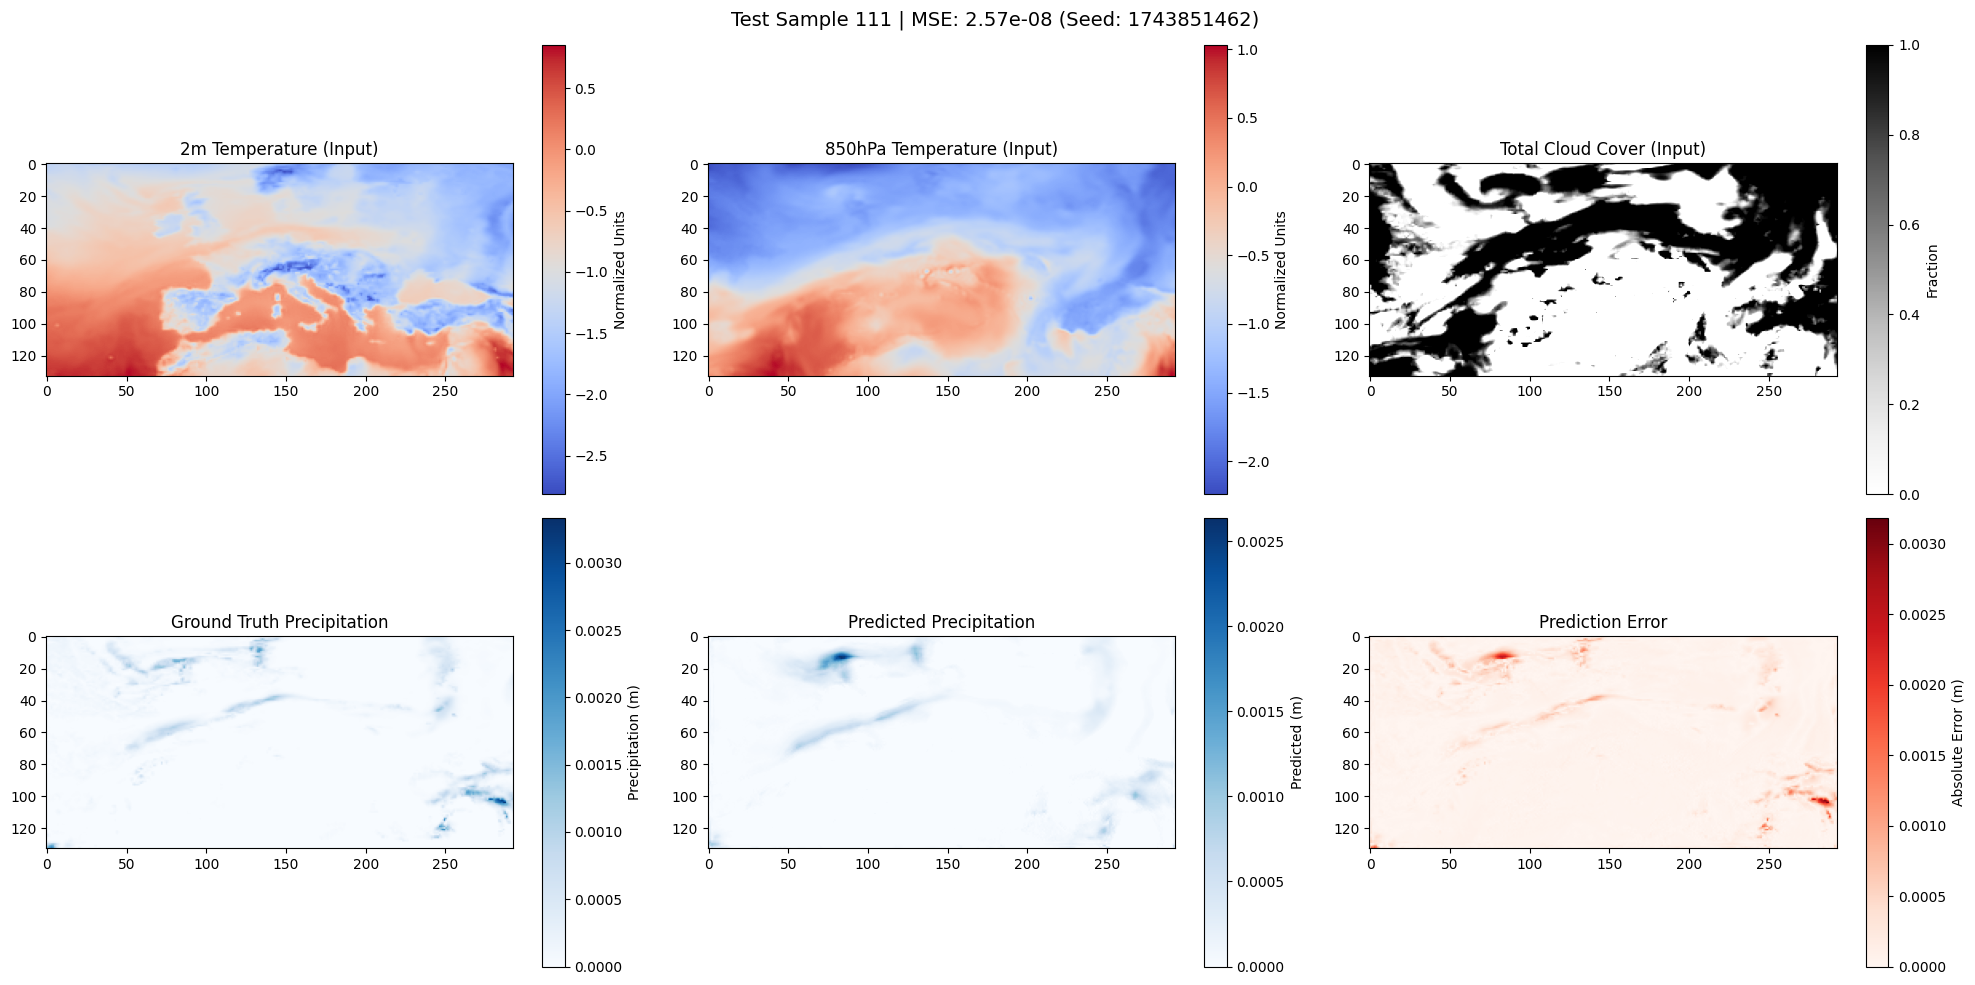

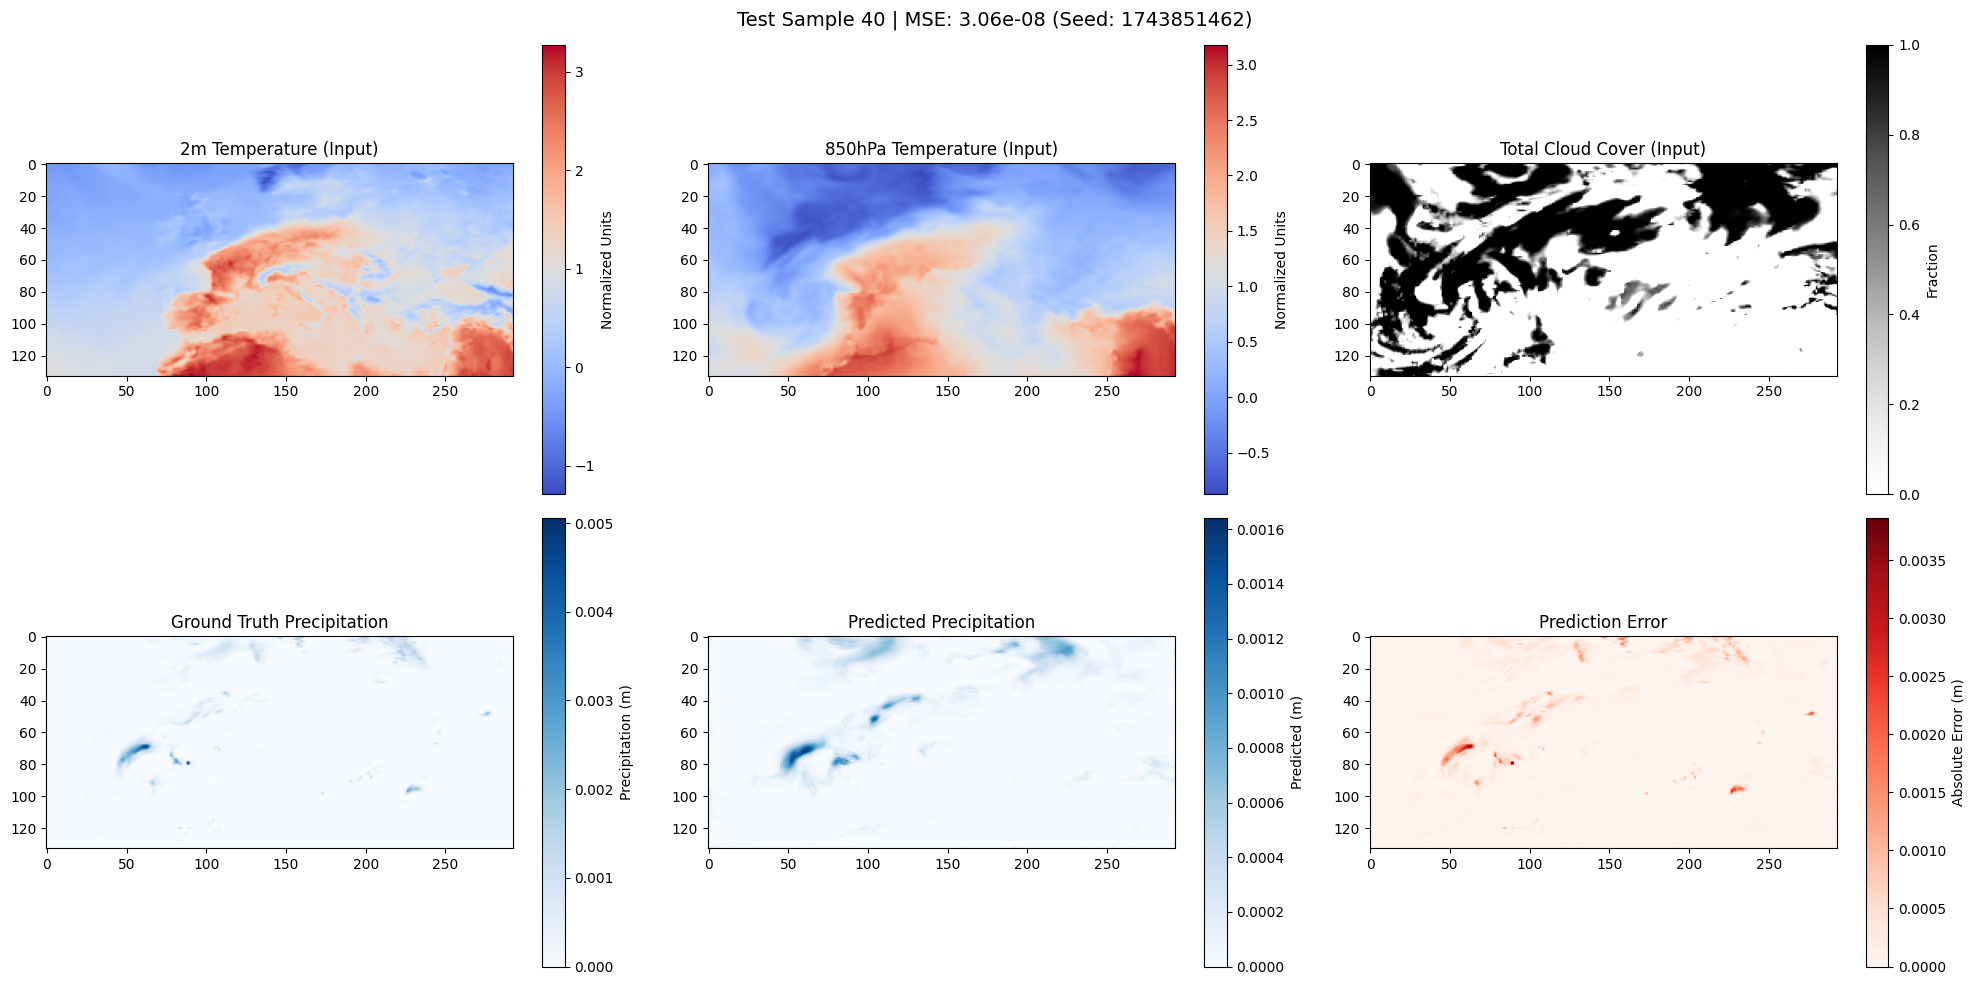

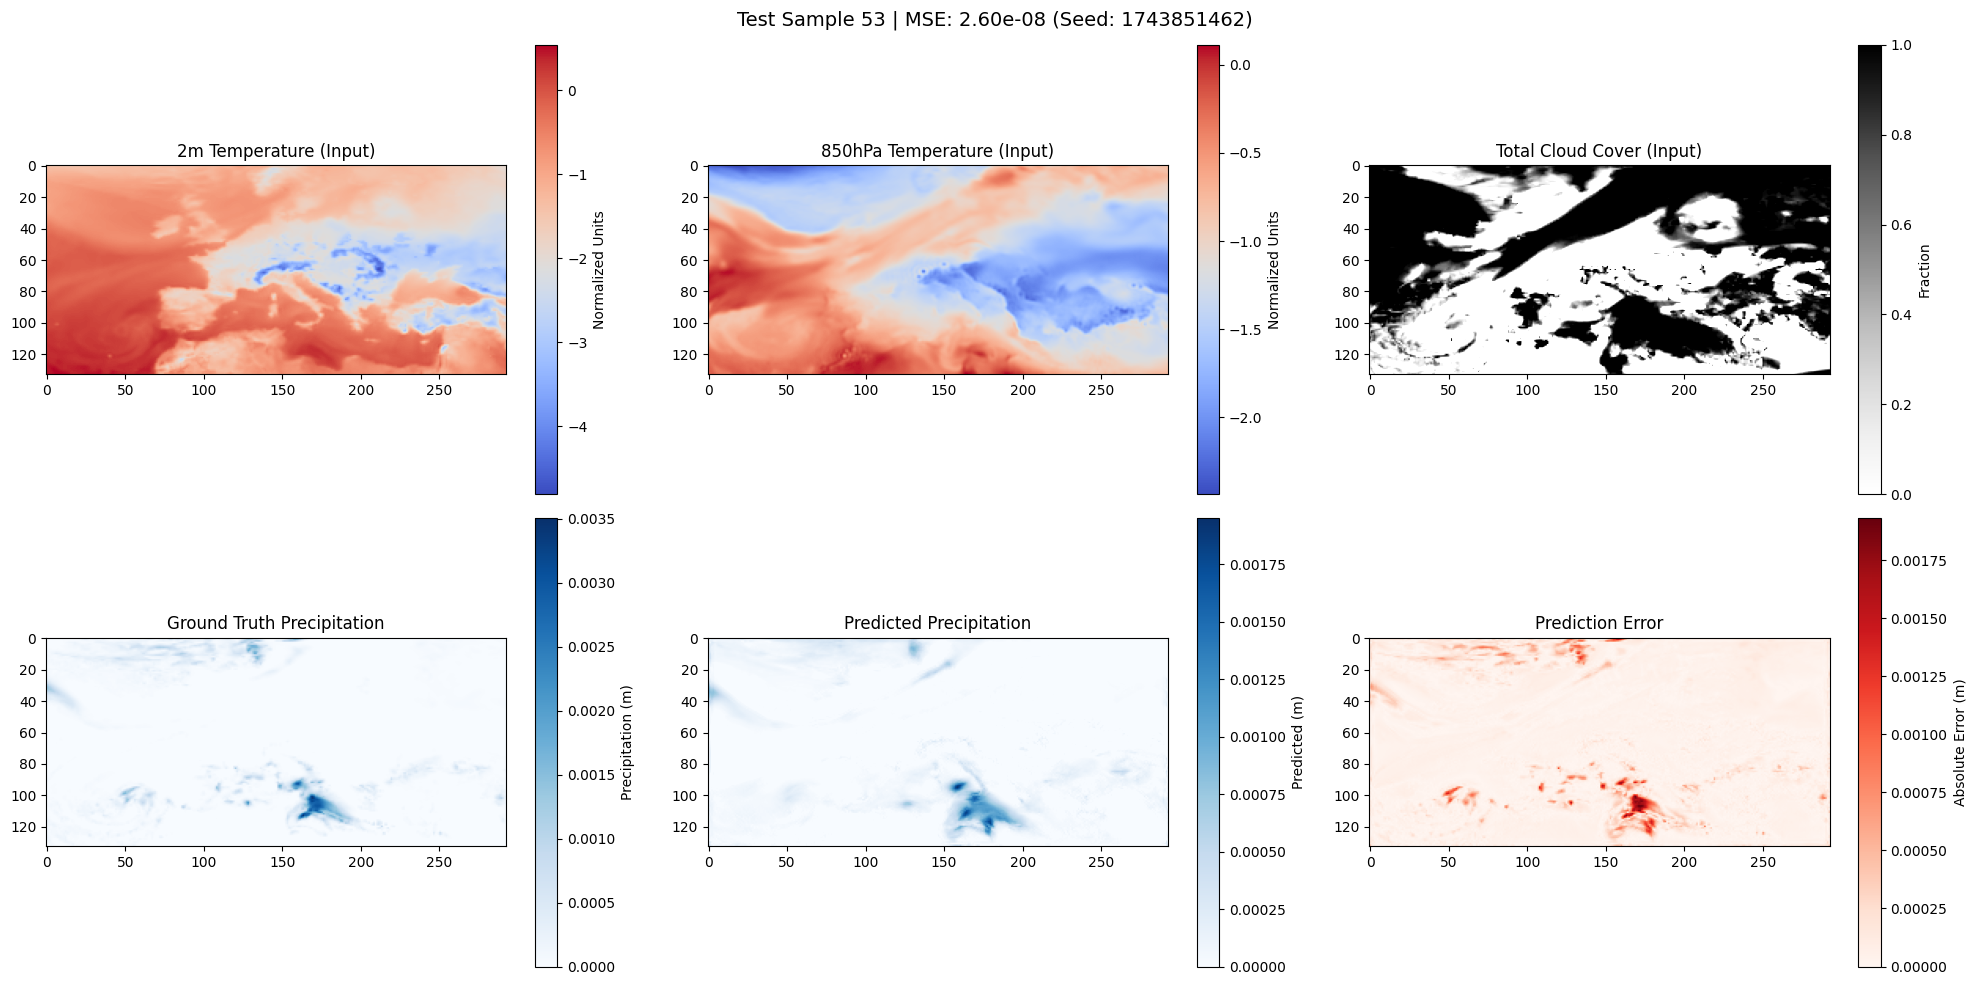

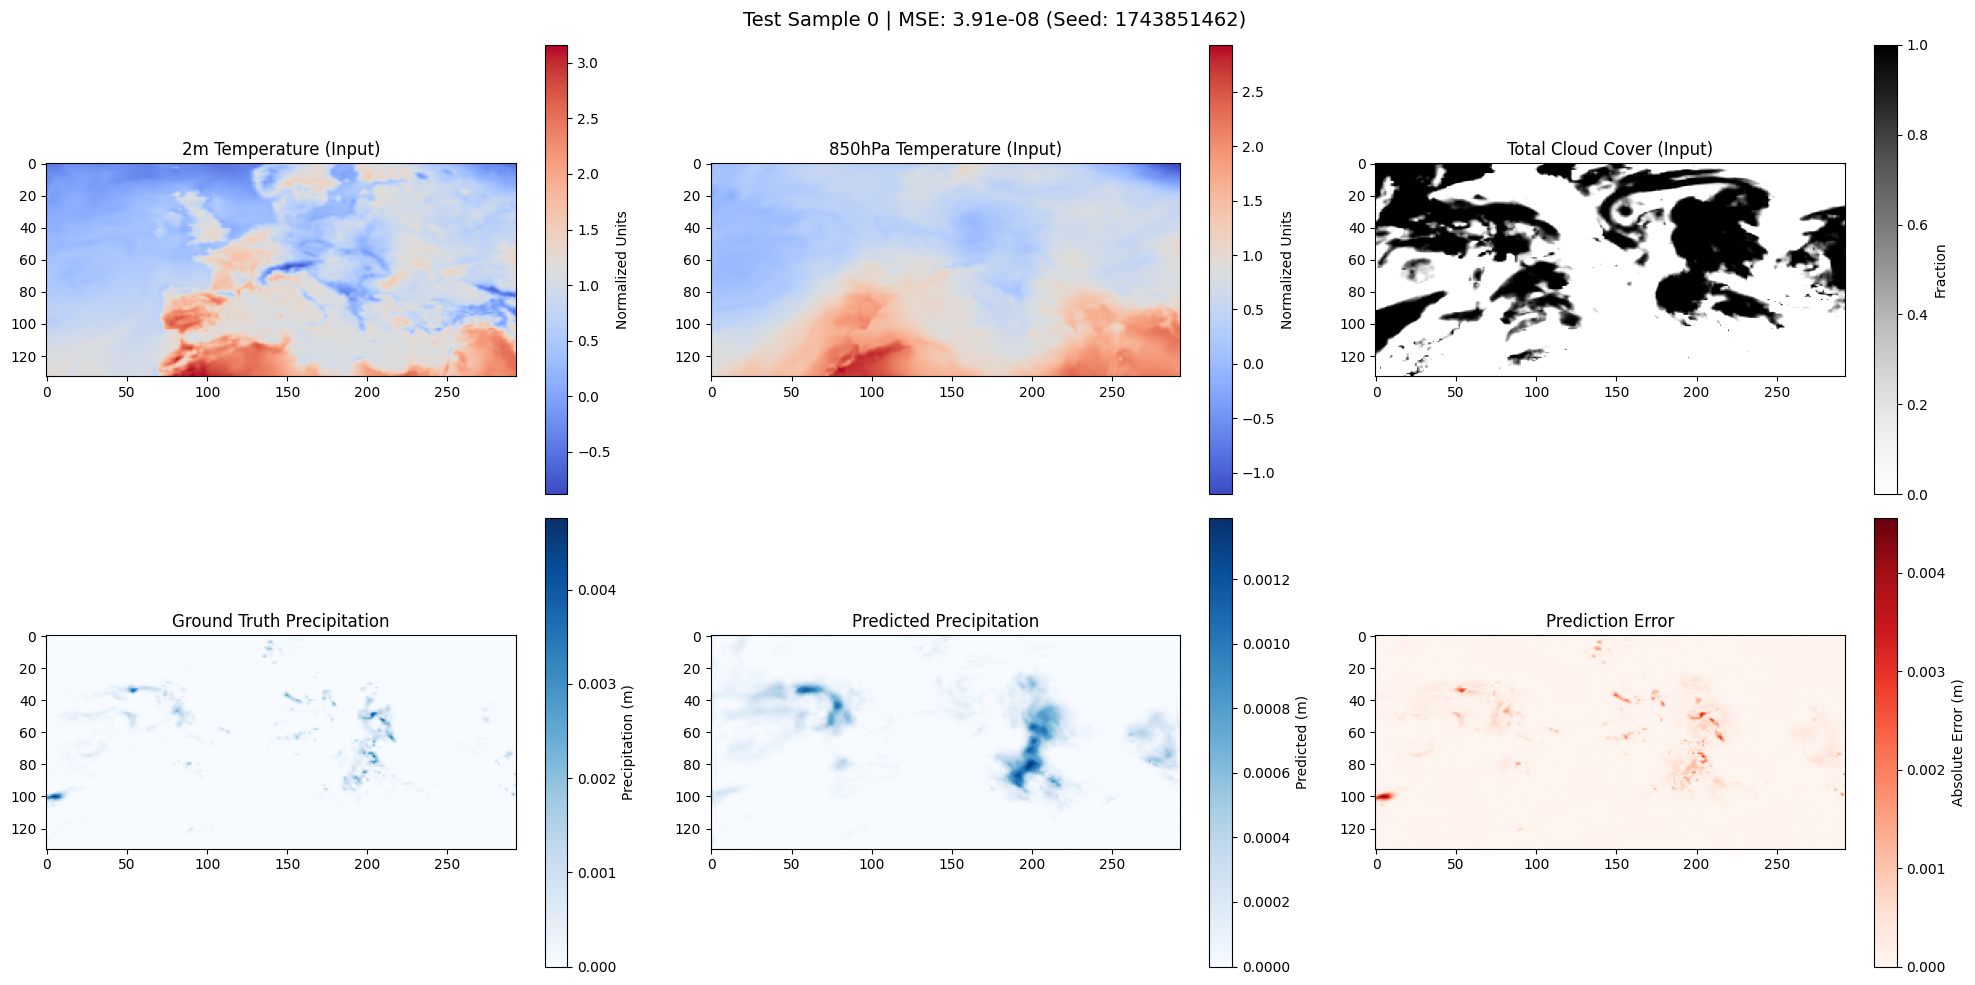

In [15]:
import time
import numpy as np
import torch
from torch.utils.data import Subset

def visualize_test_samples(model, test_loader, num_samples=4):
    # Set random seed using current time
    current_seed = int(time.time())
    np.random.seed(current_seed)
    torch.manual_seed(current_seed)
    
    print(f"Using random seed: {current_seed}")  # For reproducibility
    
    # Load the best saved model
    model.load_state_dict(torch.load("best_unet_model.pth"))
    model.eval()
    
    # Get the full test dataset
    test_dataset = test_loader.dataset
    
    # Randomly select sample indices
    all_indices = np.arange(len(test_dataset))
    selected_indices = np.random.choice(all_indices, size=num_samples, replace=False)
    
    # Create subset and data loader
    subset = Subset(test_dataset, selected_indices)
    subset_loader = torch.utils.data.DataLoader(subset, batch_size=num_samples)
    
    # Get the selected samples
    test_samples = []
    with torch.no_grad():
        for X_test, y_test in subset_loader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            preds = model(X_test)
            for i in range(X_test.size(0)):
                test_samples.append({
                    'inputs': X_test[i].cpu().numpy(),
                    'truth': y_test[i].cpu().numpy(),
                    'pred': preds[i].cpu().numpy()
                })
    
    # Rest of your visualization code...
    CHANNEL_T2M = 0
    CHANNEL_T850 = 7  
    CHANNEL_TCC = 2
    
    for i, sample in enumerate(test_samples):
        loss = np.mean((sample['pred'] - sample['truth'])**2)
        loss_str = f"{loss:.2e}" if loss < 0.001 else f"{loss:.4f}"
        
        fig = plt.figure(figsize=(20, 10))
        fig.suptitle(f"Test Sample {selected_indices[i]} | MSE: {loss_str} (Seed: {current_seed})", fontsize=14)
        
        # Plot input variables
        plt.subplot(2, 3, 1)
        plt.imshow(sample['inputs'][CHANNEL_T2M], cmap='coolwarm')
        plt.colorbar(label='Normalized Units')
        plt.title("2m Temperature (Input)")
        
        plt.subplot(2, 3, 2)
        plt.imshow(sample['inputs'][CHANNEL_T850], cmap='coolwarm')
        plt.colorbar(label='Normalized Units')
        plt.title("850hPa Temperature (Input)")
        
        plt.subplot(2, 3, 3)
        plt.imshow(sample['inputs'][CHANNEL_TCC], cmap='Greys', vmin=0, vmax=1)
        plt.colorbar(label='Fraction')
        plt.title("Total Cloud Cover (Input)")
        
        # Plot precipitation comparison
        plt.subplot(2, 3, 4)
        plt.imshow(sample['truth'].squeeze(), cmap='Blues', vmin=0)
        plt.colorbar(label='Precipitation (m)')
        plt.title("Ground Truth Precipitation")
        
        plt.subplot(2, 3, 5)
        plt.imshow(sample['pred'].squeeze(), cmap='Blues', vmin=0)
        plt.colorbar(label='Predicted (m)')
        plt.title("Predicted Precipitation")
        
        plt.subplot(2, 3, 6)
        error = np.abs(sample['pred'].squeeze() - sample['truth'].squeeze())
        plt.imshow(error, cmap='Reds', vmin=0)
        plt.colorbar(label='Absolute Error (m)')
        plt.title(f"Prediction Error")
        
        plt.tight_layout()
        plt.show()

# Usage
visualize_test_samples(model, test_loader, num_samples=4)